# **NLP News avec FinBERT**

## Installation des dépendances

In [3]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Vérifier si GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device}")
if torch.cuda.is_available():
    print(f"GPU détecté: {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Utilisation du device: cpu


In [3]:
# 1. Chargement du dataset Yahoo News
import json

def load_yahoo_data(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Charger les données
train_data = load_yahoo_data("data/yahoo/train.data")
dev_data = load_yahoo_data("data/yahoo/dev.data")
test_data = load_yahoo_data("data/yahoo/test.data")

print(f"Train: {len(train_data)} articles")
print(f"Dev: {len(dev_data)} articles")
print(f"Test: {len(test_data)} articles")

Train: 152355 articles
Dev: 5000 articles
Test: 3160 articles



Distribution des sentiments - Train
NEGATIVE  : 458129 (14.59%)
NEUTRAL   : 2066200 (65.81%)
UNK       : 453673 (14.45%)
POSITIVE  : 161420 ( 5.14%)
Total commentaires: 3139422

Distribution des sentiments - Dev
NEUTRAL   :  67500 (65.94%)
POSITIVE  :   5308 ( 5.19%)
NEGATIVE  :  14864 (14.52%)
UNK       :  14687 (14.35%)
Total commentaires: 102359

Distribution des sentiments - Test
NEUTRAL   :  43329 (63.70%)
NEGATIVE  :   9231 (13.57%)
POSITIVE  :   3418 ( 5.03%)
UNK       :  12039 (17.70%)
Total commentaires: 68017


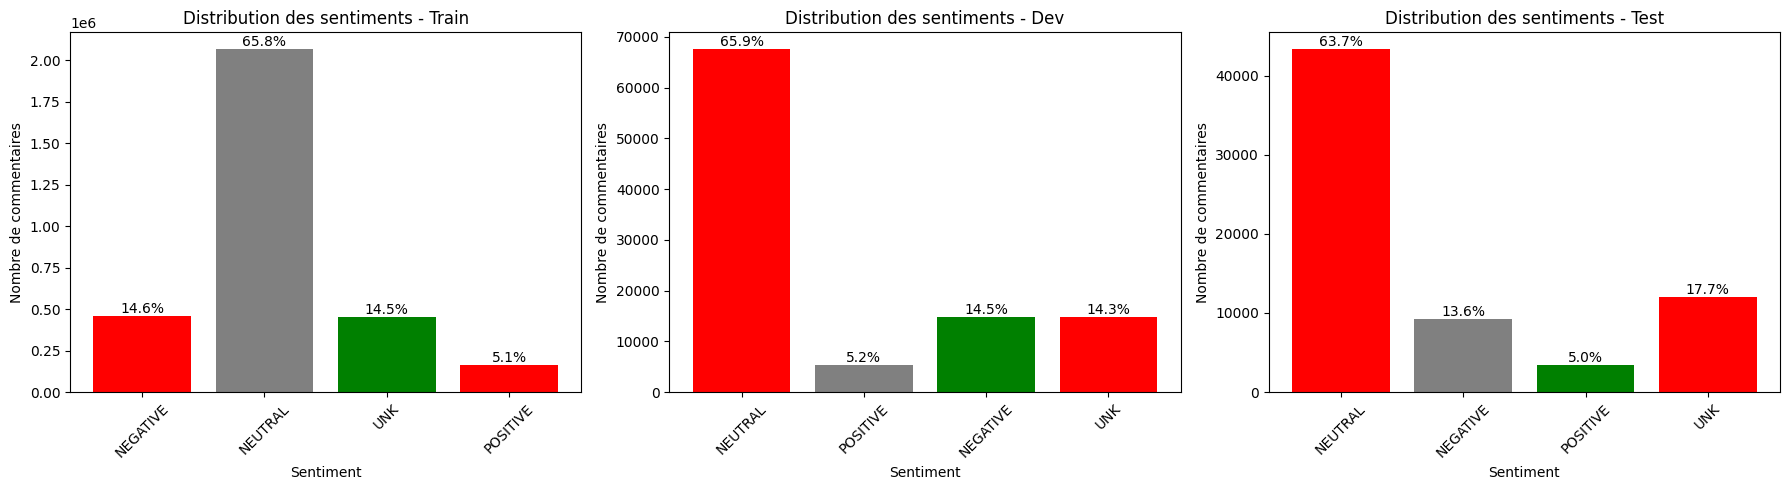

In [4]:
# Distribution des classes dans le dataset Yahoo News
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_class_distribution(data, dataset_name):
    """Analyse la distribution des sentiments dans les commentaires"""
    all_sentiments = []
    
    for article in data:
        cmts = article.get('cmts', [])
        for cmt in cmts:
            sentiment = cmt.get('sentiment', 'NEUTRAL')
            all_sentiments.append(sentiment)
    
    # Compter les occurrences
    sentiment_counts = Counter(all_sentiments)
    
    print(f"\n{'='*50}")
    print(f"Distribution des sentiments - {dataset_name}")
    print(f"{'='*50}")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(all_sentiments)) * 100
        print(f"{sentiment:10s}: {count:6d} ({percentage:5.2f}%)")
    print(f"Total commentaires: {len(all_sentiments)}")
    
    return sentiment_counts

# Analyser chaque ensemble de données
train_dist = analyze_class_distribution(train_data, "Train")
dev_dist = analyze_class_distribution(dev_data, "Dev")
test_dist = analyze_class_distribution(test_data, "Test")

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (dist, name) in enumerate([(train_dist, 'Train'), 
                                     (dev_dist, 'Dev'), 
                                     (test_dist, 'Test')]):
    sentiments = list(dist.keys())
    counts = list(dist.values())
    
    axes[idx].bar(sentiments, counts, color=['red', 'gray', 'green'])
    axes[idx].set_title(f'Distribution des sentiments - {name}')
    axes[idx].set_xlabel('Sentiment')
    axes[idx].set_ylabel('Nombre de commentaires')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Ajouter les pourcentages sur les barres
    total = sum(counts)
    for i, (sent, count) in enumerate(zip(sentiments, counts)):
        percentage = (count / total) * 100
        axes[idx].text(i, count, f'{percentage:.1f}%', 
                      ha='center', va='bottom')

plt.tight_layout()
plt.show()

Train: 6064 articles après filtrage
Dev: 191 articles après filtrage
Test: 127 articles après filtrage


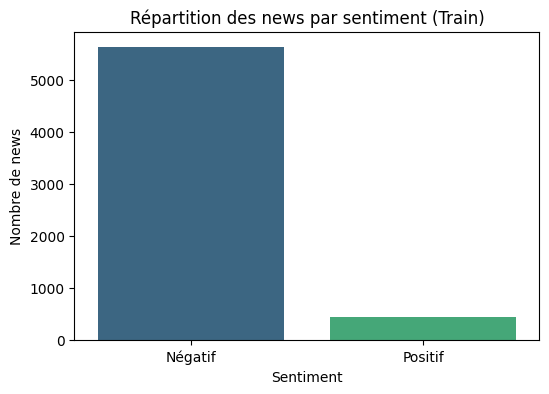

In [7]:
# 2. Prétraitement des données Yahoo News
def preprocess_yahoo_data(data):
    texts = []
    labels = []
    for article in data:
        # Combiner titre et paragraphes
        title = article.get('title', '')
        paras = article.get('paras', [])
        text = title + ' ' + ' '.join(paras)
        
        # Calculer le sentiment majoritaire des commentaires
        cmts = article.get('cmts', [])
        if not cmts:
            continue
        sentiments = [cmt.get('sentiment', 'NEUTRAL') for cmt in cmts]
        pos_count = sentiments.count('POSITIVE')
        neg_count = sentiments.count('NEGATIVE')
        neu_count = sentiments.count('NEUTRAL')
        
        if pos_count > neg_count and pos_count > neu_count:
            label = 1  # Positive
        elif neg_count > pos_count and neg_count > neu_count:
            label = 0  # Negative
        else:
            continue  # Skip if neutral majority or tie
        
        texts.append(text)
        labels.append(label)
    
    return texts, labels

# Prétraiter les données
train_texts, train_labels = preprocess_yahoo_data(train_data)
dev_texts, dev_labels = preprocess_yahoo_data(dev_data)
test_texts, test_labels = preprocess_yahoo_data(test_data)

print(f"Train: {len(train_texts)} articles après filtrage")
print(f"Dev: {len(dev_texts)} articles après filtrage")
print(f"Test: {len(test_texts)} articles après filtrage")

# Affichage de la répartition des classes
plt.figure(figsize=(6,4))
sns.countplot(x=train_labels, palette='viridis')
plt.title("Répartition des news par sentiment (Train)")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de news")
plt.xticks([0,1], ["Négatif", "Positif"])
plt.show()

ÉQUILIBRAGE DES CLASSES - TRAIN SET

📊 Distribution AVANT équilibrage :
   Classe 0 (Négatif) : 5628 (92.8%)
   Classe 1 (Positif) : 436 (7.2%)
   Ratio : 12.91:1

⚖️  Stratégie: UNDERSAMPLING (réduction classe majoritaire)

📊 Distribution APRÈS équilibrage :
   Classe 0 (Négatif) : 436 (50.0%)
   Classe 1 (Positif) : 436 (50.0%)
   Ratio : 1.00:1
   Total : 872 articles

ATTENTION : Dev et Test gardent leur distribution d'origine
Cela permet une évaluation réaliste sur des données non-biaisées


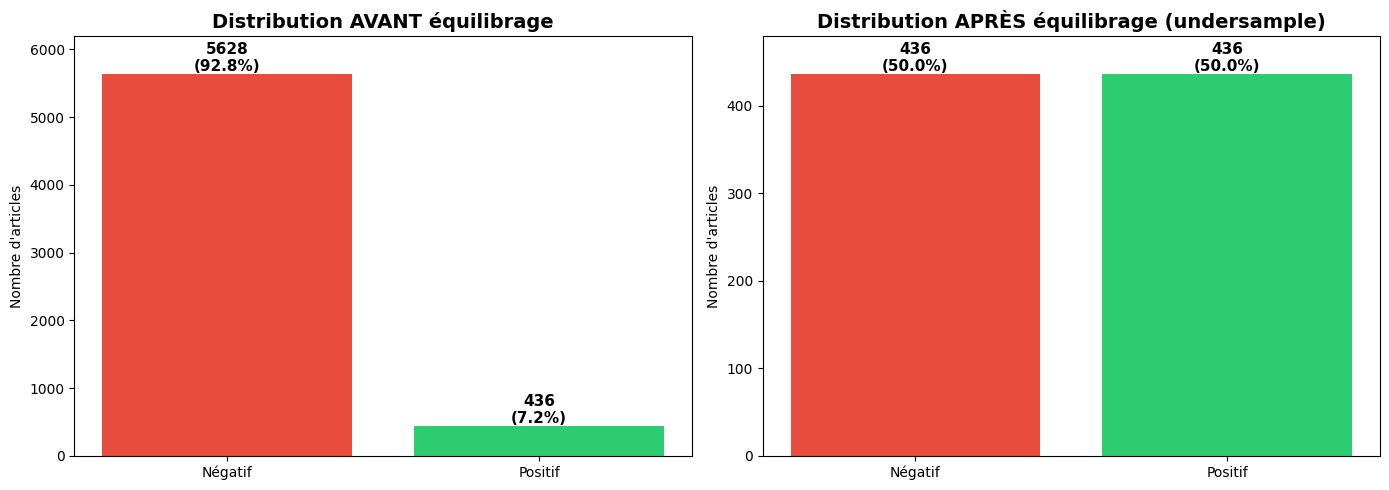


✓ Variables mises à jour :
   train_texts → train_texts_balanced (872 articles)
   train_labels → train_labels_balanced (ratio 1:1)

📋 Résumé final des données :
   Train  : 872 articles (équilibré)
   Dev    : 191 articles (distribution naturelle)
   Test   : 127 articles (distribution naturelle)


In [8]:
# 2bis. Équilibrage des classes après prétraitement
from sklearn.utils import resample
from collections import Counter

def balance_dataset(texts, labels, strategy='undersample'):
    """
    Équilibre les classes positives et négatives
    
    Args:
        texts: Liste des textes
        labels: Liste des labels (0/1)
        strategy: 'undersample' (réduire la classe majoritaire) ou 
                  'oversample' (augmenter la classe minoritaire)
    
    Returns:
        texts_balanced, labels_balanced
    """
    # Convertir en arrays numpy pour faciliter la manipulation
    texts = np.array(texts)
    labels = np.array(labels)
    
    # Compter les classes
    class_counts = Counter(labels)
    print(f"\n📊 Distribution AVANT équilibrage :")
    print(f"   Classe 0 (Négatif) : {class_counts[0]} ({class_counts[0]/len(labels)*100:.1f}%)")
    print(f"   Classe 1 (Positif) : {class_counts[1]} ({class_counts[1]/len(labels)*100:.1f}%)")
    print(f"   Ratio : {max(class_counts.values())/min(class_counts.values()):.2f}:1")
    
    # Séparer les classes
    idx_neg = np.where(labels == 0)[0]
    idx_pos = np.where(labels == 1)[0]
    
    if strategy == 'undersample':
        # Sous-échantillonner la classe majoritaire
        min_class_size = min(len(idx_neg), len(idx_pos))
        
        if len(idx_neg) > len(idx_pos):
            # Plus de négatifs, sous-échantillonner les négatifs
            idx_neg_sampled = resample(idx_neg, n_samples=min_class_size, random_state=42, replace=False)
            idx_pos_sampled = idx_pos
        else:
            # Plus de positifs, sous-échantillonner les positifs
            idx_pos_sampled = resample(idx_pos, n_samples=min_class_size, random_state=42, replace=False)
            idx_neg_sampled = idx_neg
        
        print(f"\n⚖️  Stratégie: UNDERSAMPLING (réduction classe majoritaire)")
        
    else:  # oversample
        # Sur-échantillonner la classe minoritaire
        max_class_size = max(len(idx_neg), len(idx_pos))
        
        if len(idx_neg) < len(idx_pos):
            # Moins de négatifs, sur-échantillonner les négatifs
            idx_neg_sampled = resample(idx_neg, n_samples=max_class_size, random_state=42, replace=True)
            idx_pos_sampled = idx_pos
        else:
            # Moins de positifs, sur-échantillonner les positifs
            idx_pos_sampled = resample(idx_pos, n_samples=max_class_size, random_state=42, replace=True)
            idx_neg_sampled = idx_neg
        
        print(f"\n⚖️  Stratégie: OVERSAMPLING (augmentation classe minoritaire)")
    
    # Combiner les indices
    balanced_indices = np.concatenate([idx_neg_sampled, idx_pos_sampled])
    np.random.shuffle(balanced_indices)
    
    # Créer les datasets équilibrés
    texts_balanced = texts[balanced_indices].tolist()
    labels_balanced = labels[balanced_indices].tolist()
    
    # Statistiques après équilibrage
    class_counts_after = Counter(labels_balanced)
    print(f"\n📊 Distribution APRÈS équilibrage :")
    print(f"   Classe 0 (Négatif) : {class_counts_after[0]} ({class_counts_after[0]/len(labels_balanced)*100:.1f}%)")
    print(f"   Classe 1 (Positif) : {class_counts_after[1]} ({class_counts_after[1]/len(labels_balanced)*100:.1f}%)")
    print(f"   Ratio : {max(class_counts_after.values())/min(class_counts_after.values()):.2f}:1")
    print(f"   Total : {len(labels_balanced)} articles")
    
    return texts_balanced, labels_balanced

# Appliquer l'équilibrage sur les données d'entraînement
print("="*70)
print("ÉQUILIBRAGE DES CLASSES - TRAIN SET")
print("="*70)

# Choisir la stratégie : 'undersample' ou 'oversample'
BALANCE_STRATEGY = 'undersample'  # Recommandé pour éviter l'overfitting

train_texts_balanced, train_labels_balanced = balance_dataset(
    train_texts, 
    train_labels, 
    strategy=BALANCE_STRATEGY
)

# Note : On n'équilibre généralement PAS dev et test pour garder leur distribution naturelle
print("\n" + "="*70)
print("ATTENTION : Dev et Test gardent leur distribution d'origine")
print("Cela permet une évaluation réaliste sur des données non-biaisées")
print("="*70)

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Avant équilibrage
axes[0].bar(['Négatif', 'Positif'], 
            [Counter(train_labels)[0], Counter(train_labels)[1]], 
            color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Distribution AVANT équilibrage', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Nombre d\'articles')
axes[0].set_ylim(0, max(Counter(train_labels).values()) * 1.1)
for i, (label, count) in enumerate(Counter(train_labels).items()):
    percentage = count / len(train_labels) * 100
    axes[0].text(i, count, f'{count}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Après équilibrage
axes[1].bar(['Négatif', 'Positif'], 
            [Counter(train_labels_balanced)[0], Counter(train_labels_balanced)[1]], 
            color=['#e74c3c', '#2ecc71'])
axes[1].set_title(f'Distribution APRÈS équilibrage ({BALANCE_STRATEGY})', 
                 fontsize=14, fontweight='bold')
axes[1].set_ylabel('Nombre d\'articles')
axes[1].set_ylim(0, max(Counter(train_labels_balanced).values()) * 1.1)
for i, (label, count) in enumerate(Counter(train_labels_balanced).items()):
    percentage = count / len(train_labels_balanced) * 100
    axes[1].text(i, count, f'{count}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Mettre à jour les variables pour l'entraînement
print("\n" + "="*70)
print("✓ Variables mises à jour :")
print(f"   train_texts → train_texts_balanced ({len(train_texts_balanced)} articles)")
print(f"   train_labels → train_labels_balanced (ratio 1:1)")
print("="*70)

# Utiliser les données équilibrées pour la suite
train_texts = train_texts_balanced
train_labels = train_labels_balanced

print(f"\n📋 Résumé final des données :")
print(f"   Train  : {len(train_texts)} articles (équilibré)")
print(f"   Dev    : {len(dev_texts)} articles (distribution naturelle)")
print(f"   Test   : {len(test_texts)} articles (distribution naturelle)")

In [9]:
# 3. Fonctions d'entraînement et d'évaluation
def train_epoch(model, data_loader, optimizer, criterion, device):
    """Entraîne le modèle sur une epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Métriques
        total_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        progress_bar.set_postfix({'loss': total_loss/len(data_loader), 'acc': correct/total})
    
    return total_loss / len(data_loader), correct / total

def evaluate(model, data_loader, criterion, device):
    """Évalue le modèle"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            
            total_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(data_loader), all_predictions, all_labels

def evaluate_model(y_true, y_pred, model_name):
    """Affiche les métriques d'évaluation"""
    print(f"\n{'='*50}")
    print(f"Résultats finaux - {model_name}")
    print(f"{'='*50}")
    
    # Métriques globales
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Rapport détaillé
    print("\nRapport de classification:")
    print(classification_report(y_true, y_pred, target_names=["Négatif", "Positif"]))
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Négatif", "Positif"],
                yticklabels=["Négatif", "Positif"])
    plt.title(f'Matrice de confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()

In [10]:
# 4. Préparation du Dataset pour FinBERT (News - max_length=512)
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        """
        Dataset optimisé pour les news financières longues.
        max_length=512 permet de capturer ~300-400 mots, couvrant généralement
        le titre et les premiers paragraphes (lead journalistique).
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [11]:
# 5. Chargement du modèle FinBERT pour News
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True,
    use_safetensors=True  # Utiliser safetensors pour plus de sécurité
)
model.to(device)

print(f"Modèle FinBERT chargé pour News: {model_name}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle FinBERT chargé pour News: ProsusAI/finbert


In [12]:
# 5. Création des datasets News
train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
dev_dataset = NewsDataset(dev_texts, dev_labels, tokenizer)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer)

print(f"Taille du jeu d'entraînement: {len(train_dataset)}")
print(f"Taille du jeu de validation: {len(dev_dataset)}")
print(f"Taille du jeu de test: {len(test_dataset)}")

Taille du jeu d'entraînement: 872
Taille du jeu de validation: 191
Taille du jeu de test: 127


In [13]:
# 6. Configuration de l'entraînement avec PyTorch natif (News)

# Hyperparamètres ajustés pour les news longues (max_length=512)
EPOCHS = 3
BATCH_SIZE = 4  # Batch size réduit car les séquences sont longues (512 tokens vs 128)
LEARNING_RATE = 2e-5

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Optimizer et Loss avec class weights pour gérer le déséquilibre résiduel
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids de classe
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"\n⚖️  Class weights calculés :")
print(f"   Classe 0 (Négatif) : {class_weights[0]:.3f}")
print(f"   Classe 1 (Positif) : {class_weights[1]:.3f}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Avec weights

print(f"\nConfiguration pour News (séquences longues):")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE} (réduit pour max_length=512)")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Max length: 512 tokens (~300-400 mots)")
print(f"- Loss: CrossEntropyLoss avec class weights")
print(f"- Nombre de batches d'entraînement: {len(train_loader)}")
print(f"- Nombre de batches de validation: {len(dev_loader)}")
print(f"- Nombre de batches de test: {len(test_loader)}")


⚖️  Class weights calculés :
   Classe 0 (Négatif) : 1.000
   Classe 1 (Positif) : 1.000

Configuration pour News (séquences longues):
- Epochs: 3
- Batch size: 4 (réduit pour max_length=512)
- Learning rate: 2e-05
- Max length: 512 tokens (~300-400 mots)
- Loss: CrossEntropyLoss avec class weights
- Nombre de batches d'entraînement: 218
- Nombre de batches de validation: 24
- Nombre de batches de test: 16


In [14]:
# 7. Entraînement du modèle News
print("Début de l'entraînement pour News avec FinBERT...")
best_f1 = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_f1': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")
    
    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Évaluation sur dev
    val_loss, val_preds, val_labels = evaluate(model, dev_loader, criterion, device)
    val_f1 = f1_score(val_labels, val_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    print(f"\nRésultats Epoch {epoch + 1}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Sauvegarder le meilleur modèle (nom différent pour News)
    if val_f1 > best_f1:
        best_f1 = val_f1
        model.save_pretrained('./news_best_finbert_checkpoint', safe_serialization=True)
        print(f"✓ Meilleur modèle News sauvegardé (F1: {best_f1:.4f})")

print("\n" + "="*50)
print("Entraînement terminé pour News!")
print(f"Meilleur F1-score: {best_f1:.4f}")

Début de l'entraînement pour News avec FinBERT...

Epoch 1/3


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.95it/s]



Résultats Epoch 1:
Train Loss: 0.5897 | Train Acc: 0.6927
Val Loss: 0.6147 | Val Acc: 0.6387 | Val F1: 0.3301
✓ Meilleur modèle News sauvegardé (F1: 0.3301)

Epoch 2/3


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.96it/s]



Résultats Epoch 2:
Train Loss: 0.4801 | Train Acc: 0.7626
Val Loss: 0.6188 | Val Acc: 0.6702 | Val F1: 0.3505
✓ Meilleur modèle News sauvegardé (F1: 0.3505)

Epoch 3/3


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.95it/s]



Résultats Epoch 3:
Train Loss: 0.2963 | Train Acc: 0.8876
Val Loss: 0.2953 | Val Acc: 0.8691 | Val F1: 0.5283
✓ Meilleur modèle News sauvegardé (F1: 0.5283)

Entraînement terminé pour News!
Meilleur F1-score: 0.5283


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.52it/s]



Résultats finaux - FinBERT News (max_length=512)

Accuracy:  0.8976
Precision: 0.2353
Recall:    1.0000
F1-Score:  0.3810

Rapport de classification:
              precision    recall  f1-score   support

     Négatif       1.00      0.89      0.94       123
     Positif       0.24      1.00      0.38         4

    accuracy                           0.90       127
   macro avg       0.62      0.95      0.66       127
weighted avg       0.98      0.90      0.93       127



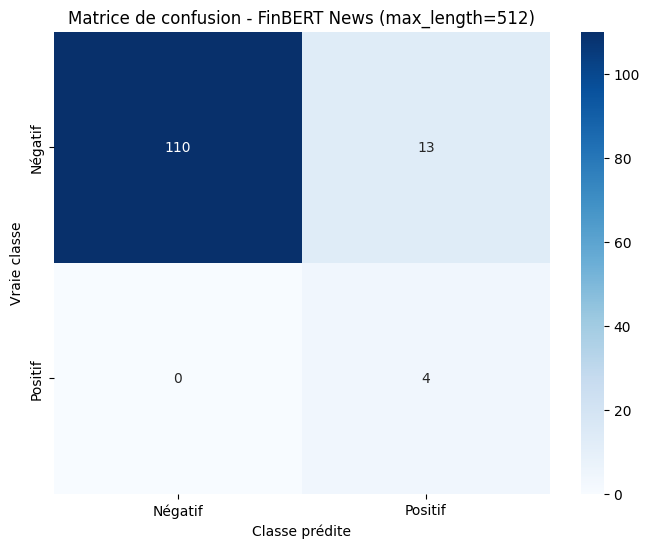

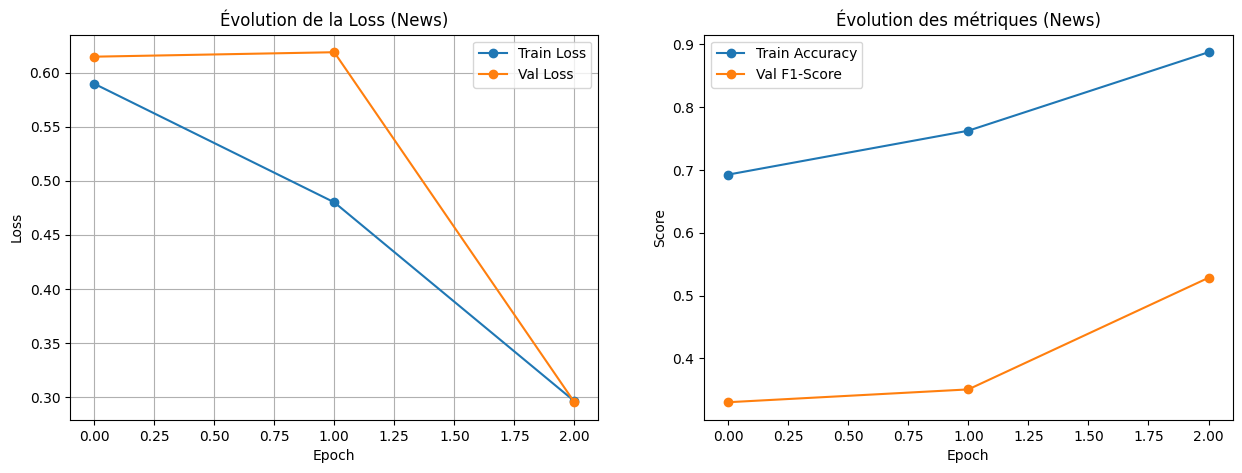

<Figure size 640x480 with 0 Axes>

In [15]:
# 8. Évaluation du modèle News
# Charger le meilleur modèle
model = AutoModelForSequenceClassification.from_pretrained(
    './news_best_finbert_checkpoint',
    num_labels=2,
    use_safetensors=True
)
model.to(device)
model.eval()

# Prédictions finales sur test
_, y_pred, y_true = evaluate(model, test_loader, criterion, device)

evaluate_model(y_true, y_pred, "FinBERT News (max_length=512)")

# Courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Évolution de la Loss (News)')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_f1'], label='Val F1-Score', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Évolution des métriques (News)')

axes[1].legend()
plt.show()

axes[1].grid(True)
plt.tight_layout()


In [16]:
# 9. Sauvegarder le modèle fine-tuné pour News
model.save_pretrained("./news_finbert_sentiment_model", safe_serialization=True)
tokenizer.save_pretrained("./news_finbert_sentiment_model")
print("✓ Modèle News sauvegardé dans ./news_finbert_sentiment_model (format safetensors)")
print("✓ Checkpoint sauvegardé dans ./news_best_finbert_checkpoint")
print("\n" + "="*50)
print("Différenciation des modèles:")
print("- Tweets: ./tweets_finbert_sentiment_model (max_length=128)")
print("- News:   ./news_finbert_sentiment_model (max_length=512)")
print("="*50)

✓ Modèle News sauvegardé dans ./news_finbert_sentiment_model (format safetensors)
✓ Checkpoint sauvegardé dans ./news_best_finbert_checkpoint

Différenciation des modèles:
- Tweets: ./tweets_finbert_sentiment_model (max_length=128)
- News:   ./news_finbert_sentiment_model (max_length=512)


In [17]:
# 10. Test du modèle sur des news réelles
import torch.nn.functional as F

def predict_sentiment_news(text, model, tokenizer, device, max_length=512):
    """
    Prédit le sentiment d'une news financière
    
    Args:
        text: Le texte de la news
        model: Le modèle fine-tuné
        tokenizer: Le tokenizer
        device: CPU ou GPU
        max_length: Longueur maximale (512 pour les news)
    
    Returns:
        dict avec le sentiment, la confiance et les probabilités
    """
    model.eval()
    
    # Tokenization
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Prédiction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1)[0]
        
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probabilities[prediction].item()
    
    sentiment_label = "Positif" if prediction == 1 else "Négatif"
    
    return {
        'sentiment': sentiment_label,
        'confidence': confidence,
        'prob_negative': probabilities[0].item(),
        'prob_positive': probabilities[1].item()
    }

# Charger le modèle final
print("Chargement du modèle fine-tuné pour les tests...")
test_model = AutoModelForSequenceClassification.from_pretrained(
    './news_finbert_sentiment_model',
    num_labels=2,
    use_safetensors=True
)
test_model.to(device)
test_tokenizer = AutoTokenizer.from_pretrained('./news_finbert_sentiment_model')
print("✓ Modèle chargé\n")

# Exemples de news financières pour test
test_cases = [
    {
        "title": "Apple Reports Record Q4 Earnings",
        "text": "Apple Inc. reported record-breaking fourth-quarter earnings, surpassing analyst expectations. The tech giant's revenue increased by 15% year-over-year, driven by strong iPhone sales and growing services revenue. CEO Tim Cook expressed optimism about future growth prospects."
    },
    {
        "title": "Tesla Stock Plummets After Production Delays",
        "text": "Tesla shares fell sharply today following announcements of significant production delays at its new factory. The company cited supply chain issues and regulatory hurdles. Investors expressed concern about the company's ability to meet its annual delivery targets."
    },
    {
        "title": "Federal Reserve Maintains Interest Rates",
        "text": "The Federal Reserve announced today that it will maintain current interest rates, citing stable economic conditions. The decision came after careful consideration of inflation data and employment figures. Markets responded positively to the news, with major indices showing modest gains."
    },
    {
        "title": "Amazon Expands Cloud Services",
        "text": "Amazon Web Services unveiled new cloud computing products aimed at enterprise customers. The expansion strengthens Amazon's position in the competitive cloud market. Analysts predict continued strong growth in the cloud services division."
    },
    {
        "title": "Banking Crisis Deepens",
        "text": "Major banks face increasing pressure as loan defaults surge. Financial analysts warn of potential systemic risks. Regulators are closely monitoring the situation and considering emergency interventions."
    }
]

# Tester le modèle sur les cas de test
print("="*80)
print("TEST DU MODÈLE SUR DES NEWS FINANCIÈRES RÉELLES")
print("="*80)

for i, case in enumerate(test_cases, 1):
    full_text = case['title'] + ' ' + case['text']
    result = predict_sentiment_news(full_text, test_model, test_tokenizer, device)
    
    print(f"\n📰 News #{i}: {case['title']}")
    print(f"{'─'*80}")
    print(f"Texte: {case['text'][:150]}...")
    print(f"\n🎯 Prédiction:")
    print(f"   • Sentiment: {result['sentiment']}")
    print(f"   • Confiance: {result['confidence']:.2%}")
    print(f"   • Prob. Négatif: {result['prob_negative']:.2%}")
    print(f"   • Prob. Positif: {result['prob_positive']:.2%}")

print("\n" + "="*80)
print("✓ Tests terminés")
print("="*80)

Chargement du modèle fine-tuné pour les tests...
✓ Modèle chargé

TEST DU MODÈLE SUR DES NEWS FINANCIÈRES RÉELLES

📰 News #1: Apple Reports Record Q4 Earnings
────────────────────────────────────────────────────────────────────────────────
Texte: Apple Inc. reported record-breaking fourth-quarter earnings, surpassing analyst expectations. The tech giant's revenue increased by 15% year-over-year...

🎯 Prédiction:
   • Sentiment: Négatif
   • Confiance: 54.82%
   • Prob. Négatif: 54.82%
   • Prob. Positif: 45.18%

📰 News #2: Tesla Stock Plummets After Production Delays
────────────────────────────────────────────────────────────────────────────────
Texte: Tesla shares fell sharply today following announcements of significant production delays at its new factory. The company cited supply chain issues and...

🎯 Prédiction:
   • Sentiment: Négatif
   • Confiance: 95.83%
   • Prob. Négatif: 95.83%
   • Prob. Positif: 4.17%

📰 News #3: Federal Reserve Maintains Interest Rates
────────────────